<a href="https://colab.research.google.com/github/Ramprabu95/AI_based_image_compression/blob/main/canopy_fuel_data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task1: Loading LAZ file and excel file

The LAZ files and the excel sheel containing the surface plot are stored in Google Drive. The first Task is to load the data.

In [182]:
!pip install laspy[laszip]
import laspy
import numpy as np
from mpl_toolkits import mplot3d

In [183]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [184]:
folder_name = "/content/drive/MyDrive/Colab Notebooks/lidarfiles/"
file_name = "CNI2020_C2_389000_4024000.laz"
# X and Y are hardcoded - This should be generalized later
X_center = 389699
Y_center = 4024175
file_path = folder_name+file_name
compressed_file = laspy.read(file_path)
uncompressed_file = laspy.convert(compressed_file)

In [185]:
import numpy as np
plot_region = laspy.create(point_format = uncompressed_file.header.point_format, file_version = uncompressed_file.header.version)
x_grid = X_center*np.ones(uncompressed_file.x.shape)
y_grid = Y_center*np.ones(uncompressed_file.y.shape)
segment = laspy.create(point_format = uncompressed_file.header.point_format, file_version = uncompressed_file.header.version)
segment.points = uncompressed_file.points[(((uncompressed_file.x-x_grid)**2)+((uncompressed_file.y-y_grid)**2)<=256)&(((uncompressed_file.x-x_grid)**2)+((uncompressed_file.y-y_grid)**2)>=16)]


In [186]:
ground = segment.points[segment.classification == 2]
vegetation = segment.points[segment.classification == 5]
vegetation_points = np.array((vegetation.x,vegetation.y,vegetation.z)).transpose()
ground_pointsxy = np.array((ground.x,ground.y)).transpose()
ground_pointsz = np.array((ground.z)).transpose()
len_ground,_ = ground_pointsxy.shape
len_veg,_ = vegetation_points.shape

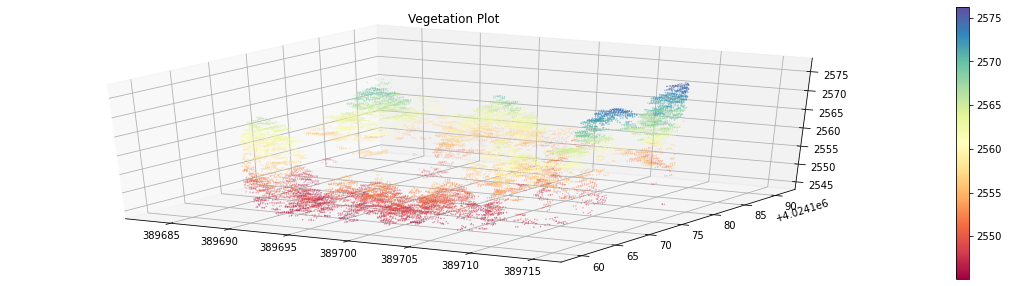

In [187]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[20, 5])
ax = plt.axes(projection='3d')
sc = ax.scatter(vegetation.x, vegetation.y, vegetation.z, c=vegetation.z ,s=0.1, marker='o', cmap="Spectral")
plt.colorbar(sc)
plt.title('Vegetation Plot')
plt.show()


In [188]:
ground_approximation = np.ones(vegetation_points.shape)
ground_approximation[:,0] = vegetation_points[:,0]
ground_approximation[:,1] = vegetation_points[:,1]
ground_approximationz = np.ones(len_veg)
min = 0
point = 0
for i in range (0,len_veg):
  x = vegetation_points[i][0]
  y = vegetation_points[i][1]
  for j in range(0,len_ground):
    distance = (ground_pointsxy[j][0]-x)**2 + (ground_pointsxy[j][1]-y)**2
    if(j == 0):
      min = distance
      point = 0
    else:
      if(distance<min):
        point = j
  ground_approximationz[i] = ground_pointsz[j]
ground_approximation[:,2] = vegetation_points[:,2]-ground_approximationz.transpose()

In [197]:
tree_max = np.ones(vegetation_points[0].shape)
for i in range(0,len_veg):
  count = 0
  if(((ground_approximation[i][2]>27) and (ground_approximation[i][2]<=28)) == True):
    #print(ground_approximation[i][2])
    range_values = []
    for j in range(0,len_veg):
      if ((((ground_approximation[j][0]-ground_approximation[i][0])**2) +((ground_approximation[j][1]-ground_approximation[i][1])**2) <=2)):
         range_values.append(j)
    #print(range_values)
    local_max = True
    for p in range_values:
      if(ground_approximation[p][2] > ground_approximation[i][2]):
        #print(ground_approximation[p][2], ground_approximation[i][2])
        local_max =False
        count += 1
    #print(count,local_max)
    if(local_max == True and count == 0):
      distance = (ground_approximation[i][0]-389699)**2 + (ground_approximation[i][1]-4024175)**2
      print(distance)
      if(distance<225 and distance>25):
        tree_max = ground_approximation[i]
      break       


74.56034899969903


[3.89690557e+05 4.02417681e+06 2.75890000e+01]


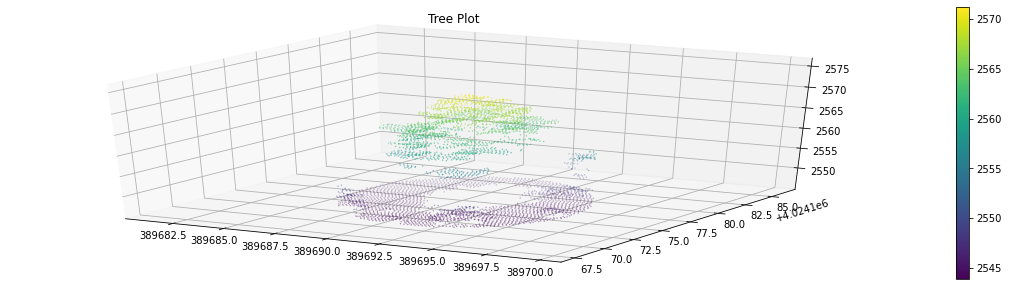

In [206]:
print(tree_max)
segment_tree = laspy.create(point_format = uncompressed_file.header.point_format, file_version = uncompressed_file.header.version)
segment_tree.points = uncompressed_file.points[(((uncompressed_file.x-tree_max[0])**2)+((uncompressed_file.y-tree_max[1])**2)<=30)]
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[20, 5])
ax = plt.axes(projection='3d')
sc = ax.scatter(segment_tree.x, segment_tree.y, segment_tree.z, c=segment_tree.z ,s=0.1, marker='o')
ax.set_xlim([tree_max[0]-10,tree_max[0]+10])
ax.set_ylim([tree_max[1]-10,tree_max[1]+10])
ax.set_zlim([np.min(vegetation_points[:,2]), np.max(vegetation_points[:,2])])
plt.colorbar(sc)
plt.title('Tree Plot')
plt.show()

In [191]:
tree_list = [[1,'PSME','D',19.6,4.8],[2,'ABCO','L',16,7.3],[3,'PIPO','L',16.1,9.1],[4,'PIPO','L',27,18.5],[5,'PIPO','L',25,18.5],[6,'PIPO','L',26.4,15.9],[7,'PIPO','L',23.4,10.8],[8,'PIEN','D',36,15.4],[9,'PIEN','L',21.1,13.9],[10,'PIEN','D',50.3,27.8]]

In [192]:
point = np.where((vegetation_points < 17.5) & (vegetation_points > 19.5))
print(point)

(array([], dtype=int64), array([], dtype=int64))


# Task2 : Finding individual tree
In the area identified, individual trees are to be isolated and classified


In [193]:
tree_list = [[1,'PSME','D',19.6,4.8],[2,'ABCO','L',16,7.3],[3,'PIPO','L',16.1,9.1],[4,'PIPO','L',27,18.5],[5,'PIPO','L',25,18.5],[6,'PIPO','L',26.4,15.9],[7,'PIPO','L',23.4,10.8],[8,'PIEN','D',36,15.4],[9,'PIEN','L',21.1,13.9],[10,'PIEN','D',50.3,27.8]]

In [194]:
print(np.min(vegetation_points[:,2]))

2545.132


In [195]:
import time
import platform
import warnings
from math import floor
from pathlib import Path

import pyximport

import numpy as np
import pandas as pd
import geopandas as gpd

import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy.spatial.distance import cdist
from scipy.signal import find_peaks
from skimage.morphology import watershed
from skimage.filters import threshold_otsu
# from skimage.feature import peak_local_max

import gdal
import osr

from shapely.geometry import mapping, Point, Polygon

from rasterio.features import shapes as rioshapes

import fiona
from fiona.crs import from_epsg

import laspy

ModuleNotFoundError: ignored

In [ ]:
class PyCrown:
   def __init__(self, las_file=None,
                 outpath=None, suffix=None):
     self.las_file  = las_file
     self.lidar_in_crowns = None
   def _get_kernel(self,radius=5, circular=True):
     print(type(radius))
     if circular:
      y, x = np.ogrid[-1*radius:radius+1, -1*radius:radius+1]
      return x**2 + y**2 <= radius**2
     else:
      return np.ones((int(radius), int(radius)))

   def _tree_detection(self,resolution=None, ws=5):
     maximum_points,_ = find_peaks(self.las_file[:,2].T)
     maximum_points,_ = find_peaks(maximum_points)
     print(maximum_points.shape)
   

In [ ]:
trial = PyCrown(las_file = lidar_points)
trial._tree_detection()